<a href="https://colab.research.google.com/github/1000century/likelion_proj2/blob/main/code/train/base_qa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install evaluate -qq
! pip install datasets -qq
! pip install bert_score -qq
! pip install rouge-score -qq
! pip install --upgrade nltk


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import gc

In [3]:
from datasets import load_dataset, Dataset, DatasetDict
import pandas as pd
import json
import os
import zipfile
from typing import List, Dict

def flatten_json_data(data_list):
    """JSON 데이터를 평탄화하는 함수"""
    return pd.json_normalize(
        data_list,
        sep='_',
        record_path=None,
        meta=[
            'category',
            'job_field',
            'gender',
            'experience',
            ['version'],
            ['dataSet', 'answer', 'raw', 'text'],
            ['dataSet', 'answer', 'summary', 'text'],
            ['dataSet', 'question', 'raw', 'text'],
            ['dataSet', 'info', 'ageRange'],
            ['dataSet', 'info', 'channel'],
            ['dataSet', 'info', 'date'],
            ['dataSet', 'info', 'experience'],
            ['dataSet', 'info', 'gender'],
            ['dataSet', 'info', 'occupation'],
            ['dataSet', 'info', 'place'],
            ['rawDataInfo', 'answer', 'audioPath'],
            ['rawDataInfo', 'question', 'audioPath']
        ]
    )

def download_and_extract(urls: List[str], base_path: str) -> None:
    """
    URL 리스트에서 ZIP 파일을 다운로드하고 압축을 해제하는 함수
    """
    os.makedirs(base_path, exist_ok=True)

    for i, url in enumerate(urls):
        zip_file_name = url.split("/")[-1]
        zip_file_path = os.path.join("/kaggle/working", zip_file_name)
        print(f'처리중... {i+1}: {zip_file_name}')

        # wget을 사용하여 파일 다운로드
        !wget -q {url} -O {zip_file_path}

        # 압축 해제할 폴더 생성
        subfolder_name = zip_file_name.replace('.zip', '')
        subfolder_path = os.path.join(base_path, subfolder_name)
        os.makedirs(subfolder_path, exist_ok=True)

        # ZIP 파일 압축 해제
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(subfolder_path)

        # 다운로드한 ZIP 파일 삭제
        os.remove(zip_file_path)

def create_dataset_from_json_files(base_path: str) -> Dataset:
    """
    주어진 경로에서 JSON 파일들을 읽어 Dataset으로 변환하는 함수
    """
    all_data = []

    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)
                        # 파일 경로에서 메타데이터 추출
                        folder_name = os.path.basename(os.path.dirname(file_path))
                        parts = folder_name.split('_')
                        data.update({
                            'category': parts[0],  # TL or VL
                            'job_field': '_'.join(parts[1:-2]),
                            'gender': parts[-2],
                            'experience': parts[-1]
                        })
                        all_data.append(data)
                except json.JSONDecodeError as e:
                    print(f"Error reading {file_path}: {e}")

    # JSON 데이터 평탄화
    df = flatten_json_data(all_data)

    # DataFrame을 Dataset으로 변환
    return Dataset.from_pandas(df)

def create_interview_dataset():
    """
    인터뷰 데이터셋을 생성하고 DatasetDict로 반환하는 함수
    """
    # 훈련 데이터 URL
    train_urls = [
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Male_New.zip"
    ]

    # 검증 데이터 URL
    valid_urls = [
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Male_New.zip"
    ]

    # 데이터 다운로드 및 압축 해제
    train_path = '/kaggle/working/train_unzipped'
    valid_path = '/kaggle/working/validation_unzipped'

    download_and_extract(train_urls, train_path)
    download_and_extract(valid_urls, valid_path)

    # 데이터셋 생성
    train_dataset = create_dataset_from_json_files(train_path)
    valid_dataset = create_dataset_from_json_files(valid_path)

    # DatasetDict 생성
    dataset_dict = DatasetDict({
        'train': train_dataset,
        'validation': valid_dataset
    })

    return dataset_dict

In [4]:
# 데이터셋 생성
dataset = create_interview_dataset()

# 데이터셋 정보 출력
print("\nDataset Info:")
print(dataset)

# 훈련 데이터 샘플 확인
print("\nTraining Data Sample:")
print(dataset['train'][0])

# 검증 데이터 샘플 확인
print("\nValidation Data Sample:")
print(dataset['validation'][0])

# 데이터셋을 로컬이나 HuggingFace Hub에 저장하기
# dataset.save_to_disk("path/to/local/directory")  # 로컬에 저장
# dataset.push_to_hub("username/dataset-name")     # HuggingFace Hub에 업로드

처리중... 1: TL_01.Management_Female_Experienced.zip
처리중... 2: TL_01.Management_Female_New.zip
처리중... 3: TL_01.Management_Male_Experienced.zip
처리중... 4: TL_01.Management_Male_New.zip
처리중... 5: TL_02.SalesMarketing_Female_Experienced.zip
처리중... 6: TL_02.SalesMarketing_Female_New.zip
처리중... 7: TL_02.SalesMarketing_Male_Experienced.zip
처리중... 8: TL_02.SalesMarketing_Male_New.zip
처리중... 9: TL_03.PublicService_Female_Experienced.zip
처리중... 10: TL_03.PublicService_Female_New.zip
처리중... 11: TL_03.PublicService_Male_Experienced.zip
처리중... 12: TL_03.PublicService_Male_New.zip
처리중... 13: TL_04.RND_Female_Experienced.zip
처리중... 14: TL_04.RND_Female_New.zip
처리중... 15: TL_04.RND_Male_Experienced.zip
처리중... 16: TL_04.RND_Male_New.zip
처리중... 17: TL_05.ICT_Female_Experienced.zip
처리중... 18: TL_05.ICT_Female_New.zip
처리중... 19: TL_05.ICT_Male_Experienced.zip
처리중... 20: TL_05.ICT_Male_New.zip
처리중... 21: TL_06.Design_Female_Experienced.zip
처리중... 22: TL_06.Design_Female_New.zip
처리중... 23: TL_06.Design_Male_Ex

In [5]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import load_dataset
import numpy as np

In [6]:
from transformers import PreTrainedTokenizerFast
tokenizer = PreTrainedTokenizerFast.from_pretrained(
    "skt/kogpt2-base-v2",
    bos_token='</s>',
    eos_token='</s>',
    unk_token='<unk>',
    pad_token='<pad>',
    mask_token='<mask>'
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer.json:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [7]:
dataset['train'][0]

{'version': '1.0',
 'category': 'TL',
 'job_field': '04.RND',
 'gender': 'Female',
 'experience': 'New',
 'dataSet_info_date': '20230116',
 'dataSet_info_occupation': 'RND',
 'dataSet_info_channel': 'MOCK',
 'dataSet_info_place': 'ONLINE',
 'dataSet_info_gender': 'FEMALE',
 'dataSet_info_ageRange': '35-44',
 'dataSet_info_experience': 'NEW',
 'dataSet_question_raw_text': '면접자분이 생각하시는 베르누이 방정식이란 무엇이라고 생각하는지 설명 부탁드리겠습니다',
 'dataSet_question_raw_wordCount': 8,
 'dataSet_question_emotion': [],
 'dataSet_question_intent': [],
 'dataSet_answer_raw_text': '아니요 베르누이 방정식은 제가 지금 이 자리에서 되게 처음 듣는 용어이구요. 일단은 제가 건설 제조업 분야에 지원한 게 아니기 때문에 지금 이게 들어맞는 건지 사실 잘 모르겠고 질문이 조금 잘못됐다는 생각이 듭니다.',
 'dataSet_answer_raw_wordCount': 32,
 'dataSet_answer_emotion': [],
 'dataSet_answer_intent': [{'category': 'attitude',
   'expression': '',
   'text': ''}],
 'dataSet_answer_summary_text': '베르누이 방정식은 제가 건설 제조업 분야에 지원한 게 아니기에 질문이 조금 잘못됐다고 생각 됩니다. 이는 제가 이 자리에서 처음 듣는 용어입니다.',
 'dataSet_answer_summary_wordCount': 21,
 'raw

In [8]:
def preprocess_training_examples(examples):
    max_length=256
    formatted_inputs = [
        f"</s> 질문: {q} 답변: {a} </s>"
        for q,a in zip(examples["dataSet_question_raw_text"],examples["dataSet_answer_raw_text"])
    ]
    inputs = tokenizer(
        formatted_inputs,
        max_length=max_length,
        truncation= True,
        padding="max_length",
        return_tensors="pt"
    )

    labels = inputs['input_ids'].clone()
    labels[labels==tokenizer.pad_token_id] = -100
    inputs['labels'] = labels
    return inputs


train_dataset = dataset['train'].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=dataset['train'].column_names,
    load_from_cache_file=False  # 이 옵션 추가
)

val_dataset = dataset['validation'].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=dataset['validation'].column_names,
    load_from_cache_file=False  # 이 옵션 추가
)

Map:   0%|          | 0/68074 [00:00<?, ? examples/s]

Map:   0%|          | 0/8026 [00:00<?, ? examples/s]

In [9]:
print(len(train_dataset))
# # 코드 잘 돌아가는지 확인 위해 train_dataset 임의로 매우 적은 개수로 샘플링
# from torch.utils.data import Subset
# train_dataset = Subset(train_dataset, indices=range(40))
# val_dataset = Subset(val_dataset, indices=range(80))
print(len(train_dataset))
print(len(val_dataset))

68074
68074
8026


# Model

In [10]:
import torch
from transformers import GPT2LMHeadModel, PreTrainedTokenizerFast

model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=51200, bias=False)
)

In [11]:
import psutil
import os

def log_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Current memory usage: {process.memory_info().rss / 1e6} MB")


In [12]:
from transformers import Trainer
import evaluate

In [13]:
import evaluate
import numpy as np
import torch
from rouge_score import rouge_scorer
meteor = evaluate.load('meteor')
bertscore = evaluate.load('bertscore')
bleu = evaluate.load('bleu')

def preprocess_logits_for_metrics(logits, labels):
    if isinstance(logits, tuple):
        logits = logits[0]
    pred_ids = torch.argmax(logits, dim=-1)
    return pred_ids, labels

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Predictions 튜플 처리
    print("\n", '='*50,"\nPredictions type:", type(predictions))
    if isinstance(predictions, tuple):
        predictions = predictions[0]
    # Predictions와 Labels를 numpy 배열로 변환
    if isinstance(predictions, torch.Tensor):
        print("Converting Predictions to numpy...")
        predictions = predictions.cpu().numpy()
    if isinstance(labels, torch.Tensor):
        print("Converting Labels to numpy...")
        labels = labels.cpu().numpy()

    # Decode predictions and labels
    print("Decoding predictions and labels...")
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 0)
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=False)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=False)

    # Post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]
    print("Decoded Predictions Sample:\n", decoded_preds[:3])
    print("Decoded Labels Sample:\n", decoded_labels[:3])

    # Calculate ROUGE metrics using rouge-score
    print("Calculating ROUGE...")
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {
        'rouge1': [],
        'rouge2': [],
        'rougeL': []
    }

    for pred, label in zip(decoded_preds, decoded_labels):
        if pred and label:  # 둘 다 비어있지 않은 경우만 계산
            scores = scorer.score(label, pred)
            rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
            rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
            rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)

    print("\nROUGE scores details:")
    print(f"Number of valid pairs: {len(rouge_scores['rouge1'])}")
    if rouge_scores['rouge1']:
        print(f"Sample ROUGE-1 scores: {rouge_scores['rouge1'][:5]}")

    rouge_result = {
        'rouge1': np.mean(rouge_scores['rouge1']) * 100 if rouge_scores['rouge1'] else 0,
        'rouge2': np.mean(rouge_scores['rouge2']) * 100 if rouge_scores['rouge2'] else 0,
        'rougeL': np.mean(rouge_scores['rougeL']) * 100 if rouge_scores['rougeL'] else 0
    }

    # Calculate other metrics
    print("Calculating METEOR...")
    meteor_result = meteor.compute(predictions=decoded_preds, references=decoded_labels)
    print("METEOR result:", meteor_result)

    print("Calculating BERTScore...")
    bertscore_result = bertscore.compute(predictions=decoded_preds, references=decoded_labels, lang="ko", device='cuda' if torch.cuda.is_available() else 'cpu')
    print("BERTScore finished")

    print("Calculating BLEU...")
    bleu_result = bleu.compute(predictions=decoded_preds, references=decoded_labels)
    print("BLEU result:", bleu_result)

    # Combine results
    result = {
        **rouge_result,
        "meteor": round(meteor_result["meteor"] * 100, 4),
        "bertscore_f1": round(np.mean(bertscore_result["f1"]) * 100, 4),
        "bleu": round(bleu_result["bleu"] * 100, 4)
    }

    print("Calculating generated length...")
    result['gen_len'] = np.mean([len(pred.split()) for pred in decoded_preds])
    print("Final Metrics:", result)

    return result

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


model.safetensors:   0%|          | 0.00/513M [00:00<?, ?B/s]

In [14]:
from transformers import Trainer, TrainingArguments

# Training arguments 설정
training_args = TrainingArguments(
    output_dir='./results',          # 모델이 저장될 경로
    evaluation_strategy="epoch",    # 매 에포크마다 평가
    save_strategy="epoch",          # 매 에포크마다 저장
    learning_rate=5e-5,             # 기본 학습률
    per_device_train_batch_size=16,  # 각 디바이스에서의 배치 사이즈
    per_device_eval_batch_size=32,   # 평가 시의 배치 사이즈
    eval_accumulation_steps=8,      # 평가 시 gradient accumulation steps
    num_train_epochs=6,             # 에포크 수
    weight_decay=0.01,              # 가중치 감쇠
    save_total_limit=2,             # 저장할 체크포인트 개수 제한
    logging_dir='./logs',           # 로깅 파일 저장 위치
    logging_steps=500,              # 로깅 빈도
    load_best_model_at_end=True,    # 가장 좋은 모델을 끝에서 로드
    eval_steps=1000,                # 평가 빈도
    fp16=True,                      # Mixed Precision (FP16) 사용
    dataloader_num_workers=4,       # DataLoader에서 사용할 워커 수
    deepspeed=None,                 # DeepSpeed는 사용하지 않음
    report_to="none",               # 로깅 서비스 (TensorBoard 등 사용하지 않음)
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
from transformers import Trainer
import numpy as np

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    compute_metrics=compute_metrics,
)

# DataLoader 확인 및 메모리 상태 출력
print(f"Total train batches: {len(trainer.get_train_dataloader())}")
print(f"Total eval batches: {len(trainer.get_eval_dataloader())}")
print(f"Batch size train: {training_args.per_device_train_batch_size}")
print(f"Batch size eval: {training_args.per_device_eval_batch_size}")
print(f"Eval accumulation steps: {training_args.eval_accumulation_steps}")

Total train batches: 4255
Total eval batches: 251
Batch size train: 16
Batch size eval: 32
Eval accumulation steps: 8


<ipython-input-15-9e0e679b52ec>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [16]:
import warnings
import os

# fork 관련 경고 제거
warnings.filterwarnings('ignore', message="os.fork()")

# tokenizer 경고 제거
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# autocast 경고 제거
warnings.filterwarnings('ignore', message="`torch.cuda.amp.autocast")

# gather 경고 제거
warnings.filterwarnings('ignore', message="Was asked to gather along dimension 0")

In [17]:
# 학습 시작
trainer.train()


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Meteor,Bertscore F1,Bleu,Gen Len
1,3.044300,3.222267,3.894383,0.100244,3.891268,11.421300,68.278400,2.294900,150.748692
2,2.880200,3.163328,3.893261,0.103941,3.890146,11.646900,67.931000,2.762400,173.994019



Predictions type: <class 'tuple'>
Decoding predictions and labels...
Decoded Predictions Sample:
 ['질문: 지원 지원 하 데 아니면 하 어 일을 다른에도 이제 어려울웠던 점이 점이 경험이방과 그 나눌 때 가장 어려웠던 점이 점이이나 있지에 대해서 말씀해 주시십시오요 답변: 일을 어려웠던 커뮤니케이션은은 제가인과의 한별러 앓고 있는 친구가배를 있었요. 그 후에게 대화를화는 가장통을 있어서조 가장 힘들습니다. 그 후 그 날 그 그서 이야기를기를 하 때 그 후구는 그 어 골 심지 물어 수가 없었까요. 그래서 날 그 그증에 어 어느은 어 다른랬울 인혔 어닫 보니였 할 되 그다 했 되는데 그 보면 해야어야 될 모르겠 그 고치가채 보고봤고 것 같요. 그 힘들 얘 힘들렇게도 많이서 어 상황 있습니다. 그래서</s>  그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그', '질문: 지원 일을 특히 강조되는지는 공직 윤리는 무엇요 한변: 공무원에게 특히 강조되는 할 공직 윤 중 청렴는 청렴결 가장 중요하다고 생각 니다. 공무원원은 국민의나 공공 다른 단체에서이나에서 일을 이익을 위해서 하는 집단이기 그래서기니 공무원 이익 충실해야 자신의이나 잘 하기 수 있는 그런 국민 대신 나은 방향으로 만들기 갈 것이이나 달성하기해야 합니다. 생각 됩니다.  때문에 저원은 청렴들을 대한 봉사자로서 생각으로 많이 합니다.요. 공무 의미에서 있어서게 공직이 자세를 가져야 것이 중요하다고 중요하다고 공직 윤라고요.목이라고 생각이 됩니다.  공무원원은 가져야야 할 덕 덕한 것은목은 가지고 

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

BERTScore finished
Calculating BLEU...
BLEU result: {'bleu': 0.022949478290059094, 'precisions': [0.3147308160595313, 0.1153827425009739, 0.05220481398293472, 0.02833117145207556], 'brevity_penalty': 0.2680766666122582, 'length_ratio': 0.43168903685547644, 'translation_length': 1322330, 'reference_length': 3063154}
Calculating generated length...
Final Metrics: {'rouge1': 3.894382912759594, 'rouge2': 0.10024363067916721, 'rougeL': 3.8912680361087095, 'meteor': 11.4213, 'bertscore_f1': 68.2784, 'bleu': 2.2949, 'gen_len': 150.74869175180663}

Predictions type: <class 'tuple'>
Decoding predictions and labels...
Decoded Predictions Sample:
 ['질문: 지원 지원 하 도중에 아니면 하 어 어 팀에도 개인 어려울웠던 점이 점이 부분이방과 그 어 때 가장 어려웠던 점은 점이이나 있지에 대해서 말씀해 주시시요 답변: 어 어려웠던 커뮤니케이션은은 어인과의 한별증이 앓고 있는 친구가배가 있었 그 그 후에게 대화화는 가장통이 있어서해를 가장 어려운습니다. 그 후 그 정도 그 말을서 이야기를기를 하 때 어 후구는 말을 말을 골 심지 잘 수 없었까요. 그래서 날 그 그한 다시 다시은 어 우울 우울울 인혔 어닫 보니 그때 할 되는 그다 했는데 되는데 그 보면 해야어야 되는 모르겠 그 고치를채 많이챘고 것 같요. 그 힘들 얘 많이도도 많이 했던 또 부분이 있습니다. 그래서</s>  그

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Meteor,Bertscore F1,Bleu,Gen Len
1,3.044300,3.222267,3.894383,0.100244,3.891268,11.421300,68.278400,2.294900,150.748692
2,2.880200,3.163328,3.893261,0.103941,3.890146,11.646900,67.931000,2.762400,173.994019
3,2.751900,3.132268,3.925590,0.114037,3.922475,11.819300,68.100800,2.672200,165.322577
4,2.652100,3.126122,3.895874,0.098253,3.892759,11.927000,68.208600,2.841900,170.993023
5,2.570200,3.119663,3.907963,0.105179,3.904848,12.031600,68.393200,2.761000,164.119362
6,2.504900,3.122530,3.908684,0.110336,3.905569,12.076300,68.326300,2.802400,167.528781



Predictions type: <class 'tuple'>
Decoding predictions and labels...
Decoded Predictions Sample:
 ['질문: 지원 지원 하 중에 아니면 하 어 어 다른에도 어 어려울웠던 점이 점이 부분이방과 그 해 수 어 어려웠던 점은 점이이나 있지에 대해서 말씀해 주시시요 답변: 어 어려웠던 커뮤니케이션은은 어인과의 한원증이 앓고 있는 친구가배가 있었요. 그 후에게 대화를화는 가장통이 있어서의 큰 큰습니다. 그 이유는 그 날 그 얘서 이야기를기를 하 때 그 친구가구는 말을 말을 골 심지 파악 수가 없었까요. 그래서 날 그 그증에 다시 다른은 그 우울 우울울 인 앓 어닫 보니였 할 되는데 그다 했 되는데 그 해야 해야어야 될 모르겠 그 고치를채 보고봤고 것 같요. 그 힘들 울 울를도 좀 했던 또 부분이 있어서 그래서</s>  그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그 그', '질문: 지원 일을 특히 강조되는지는 공직 윤리는 무엇요 한변: 공무원에게 특히 강조되는 할 공직 윤란 청렴는 청렴결 가장 중요하다고 생각 니다. 공무원원은 국민의 기관 공 공 단체에서이나에서 일을 이익을 위해서 일을 집단이기 그렇기기니 공무원 이익 충실해야 또원 잘 하기 수 있는 그런 알고 대신 잘 방향으로 만들기가는 중요한이나 가지고해야 합니다. 생각 됩니다. 그래서 때문에 공무원원은 청렴에 대한 봉사자로서 생각으로 꼭 합니다.요. 그렇기 봉사 있어서게 청렴이 공직 가져야 것이 중요하다고 중요하다고 공직 윤리라고 또목이라고 생각이 됩니다.  공무원원은 가져야야 할 가장 청렴한 것은목 가지고 

There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=25530, training_loss=2.7575182456387477, metrics={'train_runtime': 10743.4004, 'train_samples_per_second': 38.018, 'train_steps_per_second': 2.376, 'total_flos': 5.3361581359104e+16, 'train_loss': 2.7575182456387477, 'epoch': 6.0})

In [18]:
import os
import shutil

# 모델 가중치와 설정 저장
trainer.save_model("./results/best_model")

# 학습 상태 저장
trainer.save_state()

In [29]:
import torch

# GPU 상태 초기화 및 남은 메모리 확인
for i in range(torch.cuda.device_count()):
    device = torch.device(f"cuda:{i}")

    # 메모리 초기화
    torch.cuda.empty_cache()  # GPU 캐시 비우기
    torch.cuda.ipc_collect()  # GPU 메모리에서 누수된 객체 수집

    # 메모리 통계 초기화
    torch.cuda.reset_max_memory_allocated(device)
    torch.cuda.reset_peak_memory_stats(device)

    # GPU 메모리 상태 확인
    total_memory = torch.cuda.get_device_properties(device).total_memory  # 전체 메모리
    reserved_memory = torch.cuda.memory_reserved(device)  # 예약된 메모리
    allocated_memory = torch.cuda.memory_allocated(device)  # 사용 중인 메모리
    free_memory = reserved_memory - allocated_memory  # 예약된 메모리 중 사용 가능 메모리

    print(f"GPU {i} 메모리 리셋 완료!")
    print(f"  전체 메모리: {total_memory / 1024 ** 2:.2f} MB")
    print(f"  예약된 메모리: {reserved_memory / 1024 ** 2:.2f} MB")
    print(f"  사용 중인 메모리: {allocated_memory / 1024 ** 2:.2f} MB")
    print(f"  사용 가능 메모리: {free_memory / 1024 ** 2:.2f} MB")


GPU 0 메모리 리셋 완료!
  전체 메모리: 22699.88 MB
  예약된 메모리: 3188.00 MB
  사용 중인 메모리: 2068.50 MB
  사용 가능 메모리: 1119.50 MB


/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [20]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Best Model 로드
best_model = AutoModelForCausalLM.from_pretrained("./results/best_model")

# GPU 설정
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 입력 프롬프트
prompt ="본인의 강점이 무엇이라고 생각하시나요"  # 텍스트 생성 시작 문장
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

# 텍스트 생성
output = model.generate(
    input_ids,
    max_length=250,            # 생성할 최대 길이
    num_beams=5,               # 빔 서치 크기
    no_repeat_ngram_size=2,    # 반복 방지
    early_stopping=True,       # 적절히 멈춤
    temperature=0.7            # 생성 다양성 제어 (0.7~1.0 추천)
)

# 결과 디코딩
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print("Generated Text:")
print(generated_text)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Generated Text:
본인의 강점이 무엇이라고 생각하시나요 또한 지원자님께서 그렇게 생각하시는 이유에 대해서도 함께 말씀해 주실 수 있을까요 답변: 네 저는 어떤 일을 함에 있어서 그 일에 대한 집중도가 굉장히 높은 편입니다. 그래서 어떤 일이 주어지더라도 그 일을 잘 해낼 수 있다는 그런 자신감을 항상 가지고 있습니다. 그리고 어떤 환경에서도 잘 적응할 수 있는 그런 성격을 가지고 있기 때문에 어떤 환경이 주어진다 하더라도 그 환경에 잘 적응해서 일을 해 나갈 수 있다고 생각합니다. 그리고 항상 어떤 작업을 수행함에 있어서 어 집중력이 상당히 높은 편이라서 어떤 작업도 잘 수행해 낼 수 있고 또 좋은 결과를 만들어 낼 수도 있습니다. 그래서 항상 어 일을 할 때는 집중력을 많이 가지고 일을 해야 된다고 생각됩니다. 그리고 어 어떤 환경에서 일을 하든 어떤 환경에 처하든 어 저에게 주어진 일에 최선을 다해서 임해야 된다고 봅니다. 그래야만 좋은 결과와 좋은 결과가 나올 수 있기 때문입니다. 그리고 저 또한 어떤 일에 임했을 때 항상 긍정적인 사고방식을 가지고 임하려고 노력하고 있습니다. 그렇게 하다 보면은 어떤 어려운 일이나 어려운 일이 닥치더래도 그것을 잘 극복할 수 있습니다. 아무리 좋은 환경이라 하더라도 그것을 회피하거나 회피한다면 또 다른 일을 맡기거나 할 수 없기 때문에 그렇습니다. 항상 주어지는 일에는 최


In [21]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Best Model 로드
best_model = AutoModelForCausalLM.from_pretrained("./results/best_model")

# GPU 설정
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 입력 프롬프트
prompt ="저희 회사가 당신을 뽑아야 하는 이유를 설명하세요"  # 텍스트 생성 시작 문장
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

# 텍스트 생성
output = model.generate(
    input_ids,
    max_length=250,             # 생성할 최대 길이
    num_beams=5,               # 빔 서치 크기
    no_repeat_ngram_size=2,    # 반복 방지
    early_stopping=True,       # 적절히 멈춤
    temperature=0.7            # 생성 다양성 제어 (0.7~1.0 추천)
)

# 결과 디코딩
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print("Generated Text:")
print(generated_text)

Generated Text:
저희 회사가 당신을 뽑아야 하는 이유를 설명하세요 답변: 저는 회사의 덕목이 무엇이라고 생각하십니까. 어떤 회사가 좋은 회사라고 생각하는지 궁금합니다 라고 질문하셨습니다. 거기에 대한 저의 답변을 말씀드리겠습니다. 먼저 제가 생각하는 좋은 회사는 첫째 이윤 추구가 최우선입니다. 둘째 함께 성장해 나가는 회사입니다. 셋째 함께 성장할 수 있는 회사라 생각됩니다. 넷째 함께 성장하는 회사가 덕목입니다. 제가 입사를 하게 된다면 어떤 일이든 맡겨만 주신다면 열심히 할 자신이 있습니다. 이상 제가 회사에 입사한 후 제가 어떤 일을 하는지에 대해 말씀드렸습니다. 감사합니다. 


In [32]:
trainer

In [33]:
import pandas as pd

def text_to_df(text):
    # 문자열을 StringIO로 변환하여 read_csv로 읽기
    from io import StringIO
    df = pd.read_csv(StringIO(text), sep='\t', index_col='Epoch')
    return df

# 사용 예시
text = """Epoch	Training Loss	Validation Loss	Rouge1	Rouge2	Rougel	Meteor	Bertscore F1	Bleu	Gen Len
1	3.044300	3.222267	3.894383	0.100244	3.891268	11.421300	68.278400	2.294900	150.748692
2	2.880200	3.163328	3.893261	0.103941	3.890146	11.646900	67.931000	2.762400	173.994019
3	2.751900	3.132268	3.925590	0.114037	3.922475	11.819300	68.100800	2.672200	165.322577
4	2.652100	3.126122	3.895874	0.098253	3.892759	11.927000	68.208600	2.841900	170.993023
5	2.570200	3.119663	3.907963	0.105179	3.904848	12.031600	68.393200	2.761000	164.119362
6	2.504900	3.122530	3.908684	0.110336	3.905569	12.076300	68.326300	2.802400	167.528781
"""

history_df = text_to_df(text)
print(history_df)

       Training Loss  Validation Loss    Rouge1    Rouge2    Rougel   Meteor  \
Epoch                                                                          
1             3.0443         3.222267  3.894383  0.100244  3.891268  11.4213   
2             2.8802         3.163328  3.893261  0.103941  3.890146  11.6469   
3             2.7519         3.132268  3.925590  0.114037  3.922475  11.8193   
4             2.6521         3.126122  3.895874  0.098253  3.892759  11.9270   
5             2.5702         3.119663  3.907963  0.105179  3.904848  12.0316   
6             2.5049         3.122530  3.908684  0.110336  3.905569  12.0763   

       Bertscore F1    Bleu     Gen Len  
Epoch                                    
1           68.2784  2.2949  150.748692  
2           67.9310  2.7624  173.994019  
3           68.1008  2.6722  165.322577  
4           68.2086  2.8419  170.993023  
5           68.3932  2.7610  164.119362  
6           68.3263  2.8024  167.528781  


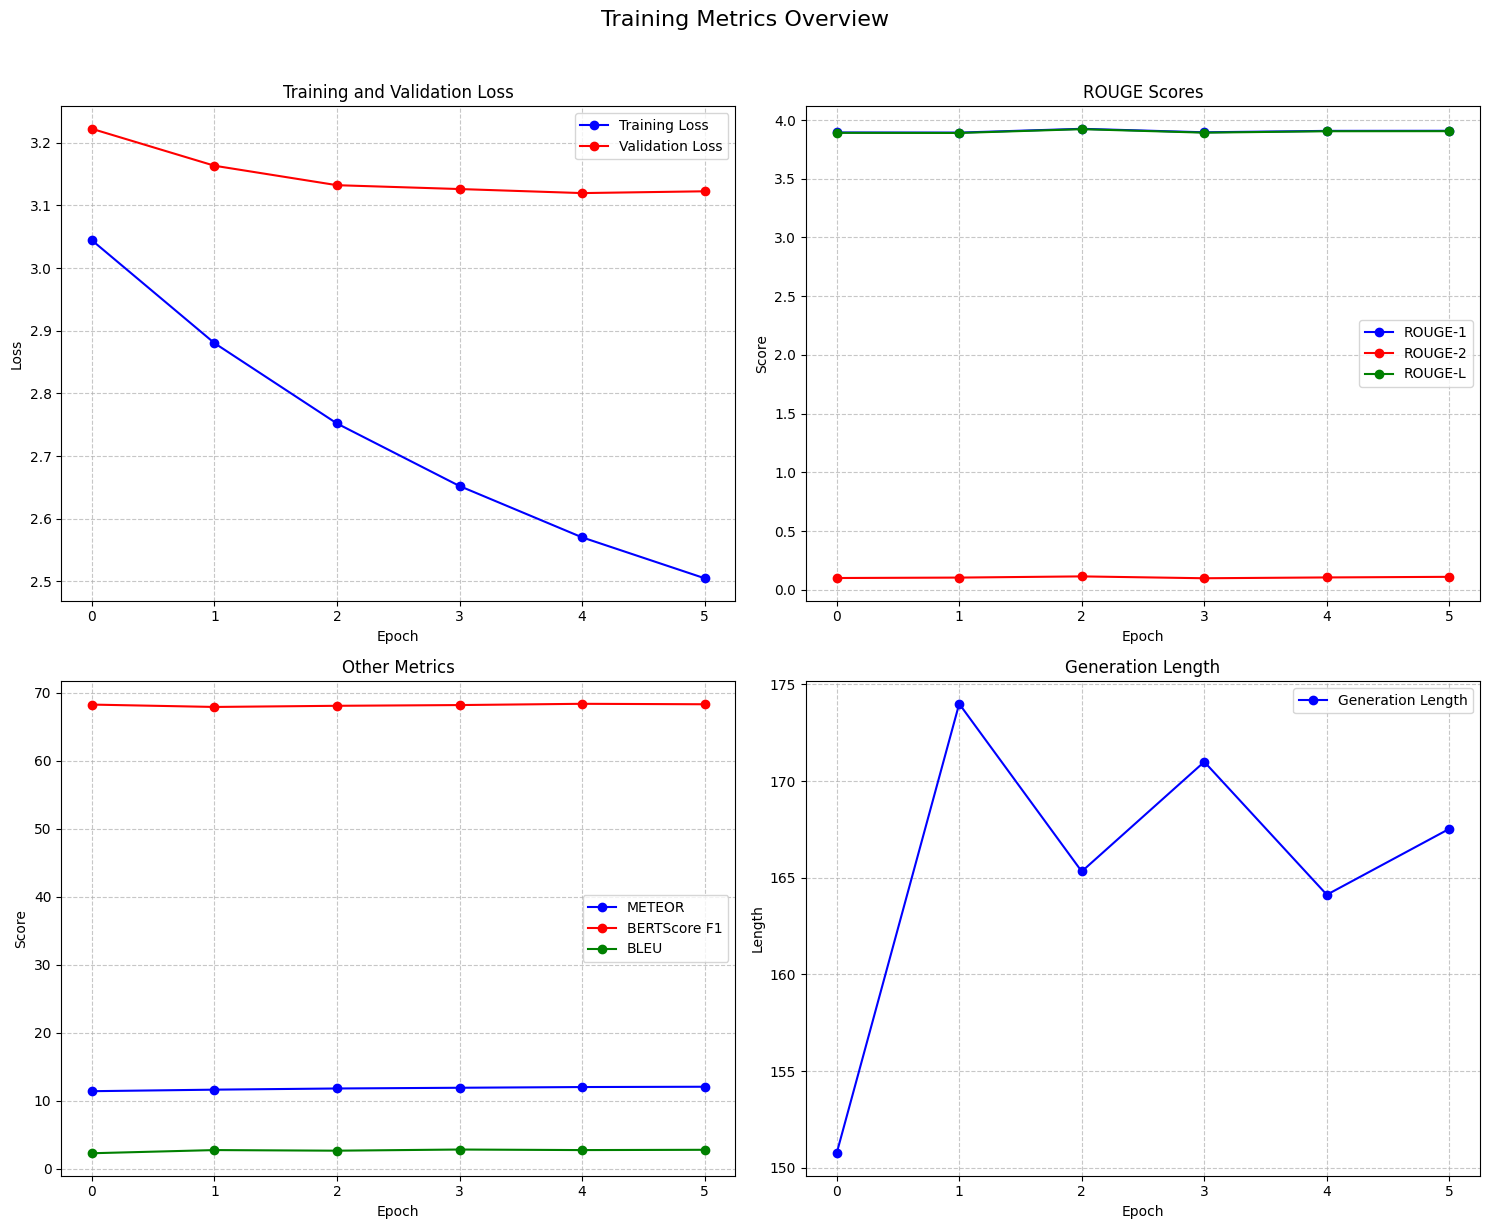


Final Metrics:
Train Loss: 2.5049
Validation Loss: 3.1225
ROUGE-1: 3.9087
ROUGE-2: 0.1103
ROUGE-L: 3.9056
METEOR: 12.0763
BERTScore: 68.3263
BLEU: 2.8024
Generation Length: 167.5288


In [34]:
import matplotlib.pyplot as plt
import numpy as np

# nan 값을 제외하고 데이터 추출
train_loss = history_df['Training Loss'].dropna().values
eval_loss = history_df['Validation Loss'].dropna().values
rouge1 = history_df['Rouge1'].dropna().values
rouge2 = history_df['Rouge2'].dropna().values
rougeL = history_df['Rougel'].dropna().values
meteor = history_df['Meteor'].dropna().values
bertscore = history_df['Bertscore F1'].dropna().values
bleu = history_df['Bleu'].dropna().values
gen_len = history_df['Gen Len'].dropna().values

# 실제 데이터 개수에 맞춰 epochs 배열 생성
epochs = np.arange(len(eval_loss))

# 그래프 생성
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Training Metrics Overview', fontsize=16, y=1.02)

# Loss plot
ax1.plot(epochs, train_loss, 'b-', label='Training Loss', marker='o')
ax1.plot(epochs, eval_loss, 'r-', label='Validation Loss', marker='o')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)

# ROUGE scores over time
ax2.plot(epochs, rouge1, 'b-', label='ROUGE-1', marker='o')
ax2.plot(epochs, rouge2, 'r-', label='ROUGE-2', marker='o')
ax2.plot(epochs, rougeL, 'g-', label='ROUGE-L', marker='o')
ax2.set_title('ROUGE Scores')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Score')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)

# Other metrics
ax3.plot(epochs, meteor, 'b-', label='METEOR', marker='o')
ax3.plot(epochs, bertscore, 'r-', label='BERTScore F1', marker='o')
ax3.plot(epochs, bleu, 'g-', label='BLEU', marker='o')
ax3.set_title('Other Metrics')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Score')
ax3.legend()
ax3.grid(True, linestyle='--', alpha=0.7)

# Generation length
ax4.plot(epochs, gen_len, 'b-', label='Generation Length', marker='o')
ax4.set_title('Generation Length')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Length')
ax4.legend()
ax4.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

# 그래프 저장
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# 최종 결과값들 출력
print("\nFinal Metrics:")
print(f"Train Loss: {train_loss[-1]:.4f}")
print(f"Validation Loss: {eval_loss[-1]:.4f}")
print(f"ROUGE-1: {rouge1[-1]:.4f}")
print(f"ROUGE-2: {rouge2[-1]:.4f}")
print(f"ROUGE-L: {rougeL[-1]:.4f}")
print(f"METEOR: {meteor[-1]:.4f}")
print(f"BERTScore: {bertscore[-1]:.4f}")
print(f"BLEU: {bleu[-1]:.4f}")
print(f"Generation Length: {gen_len[-1]:.4f}")